This program compare ARIMA, ANN, and combination of them as hybrid method to predict time series data

Imports

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import util as utl
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn import preprocessing
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.layers.recurrent import LSTM
from statsmodels.tsa.stattools import pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cfg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn import preprocessing
from statsmodels.tsa.stattools import acf
from keras.layers import LSTM

Loading data from dataset and showing raw data

total samples: 1827


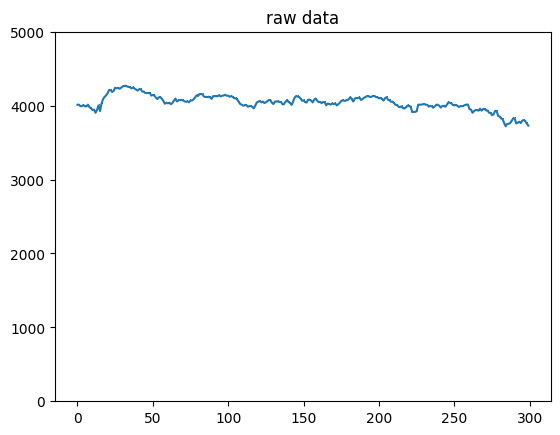

In [43]:
# loading data
ls_data = utl.read_data(cfg.csv_path)
ls_data = ls_data[0:300]
start_outlayer = 50
# showing data
plt.close('all')
plt.title('raw data')
plt.ylim(cfg.ylim)
plt.plot(ls_data, marker=',')
plt.show()

Splitting data into test and train

In [44]:

trn_count = int(len(ls_data) * cfg.trn_sz)
train, test = ls_data[0:trn_count], ls_data[trn_count:len(ls_data)]

print('# sample train: ' + str(trn_count))
print('# sample test: ' + str(len(test)))


# sample train: 150
# sample test: 150


Training ARIMA in rolling mode

In [45]:
model = ARIMA(train,
              order=(
                  cfg.ARIMA_p1,
                  cfg.ARIMA_p2,
                  cfg.ARIMA_p3))

model_fit = model.fit()

Measuring auto correlation function and partial auto correlation function

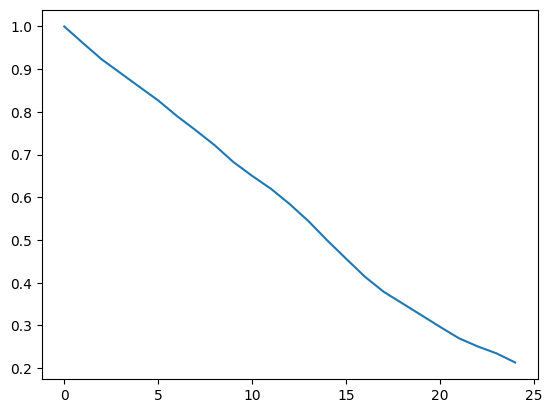

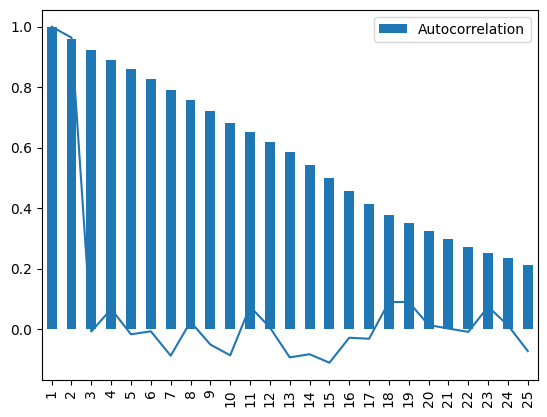

In [46]:
auto_corr_func = acf(ls_data)
plt.plot(auto_corr_func)
df = pd.DataFrame([auto_corr_func]).T
df.columns = ["Autocorrelation"]
df.index += 1
df.plot(kind='bar')
par_auto_corr_func = pacf(ls_data)
plt.plot(par_auto_corr_func)
plt.show()
#test_df = pd.DataFrame([pacf_1]).T


Training ARIMA in rolling mode

In [47]:
arima_pred, resid_test = [], []
history = train
for t in range(len(test)):
    model = ARIMA(history,
                  order=(
                      cfg.ARIMA_p1,
                      cfg.ARIMA_p2,
                      cfg.ARIMA_p3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    resid_test.append(test[t] - output[0])
    arima_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    if cfg.shw_ARIMA:
        print(
            str(t) + ' - ' + 'predicted=%f, expected=%f' % (yhat, obs))

Printing and visualizing ARIMA performance of rolling mode

MSE (ARIMA): 15699197.320
ME (ARIMA): 3961.017
MAE (ARIMA): 3961.017
MAPE (ARIMA): 77820.765


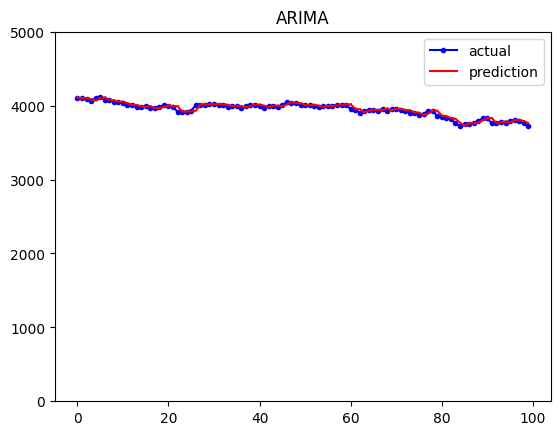

In [48]:
test_resid = []
for i in resid_test:
    test_resid.append(i)
    
utl.print_errors(
    'ARIMA',
    test_resid[start_outlayer:],
    arima_pred[start_outlayer:])

plt.title('ARIMA')
plt.ylim(cfg.ylim)
plt.plot(
    test[start_outlayer:],
    label='actual',
    color='blue',
    marker='.')
plt.plot(
    arima_pred[start_outlayer:],
    label='prediction',
    color='red',
    marker=',')
plt.legend()
plt.show()

All mode training of ARIMA

In [49]:
#train, test = ls_data[0:trn_count], ls_data[trn_count:len(ls_data)]
model = ARIMA(
    train,
    order=(
        cfg.ARIMA_p1,
        cfg.ARIMA_p2,
        cfg.ARIMA_p3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1370.172
Date:                Sun, 31 Mar 2024   AIC                           2746.344
Time:                        00:45:26   BIC                           2757.455
Sample:                             0   HQIC                          2750.791
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3990.3506     84.393     47.283      0.000    3824.943    4155.758
ar.L1          0.9842      0.012     82.350      0.000       0.961       1.008
sigma2       536.4973     30.827     17.404      0.0

Residual diagnostics and additional info of all mode training

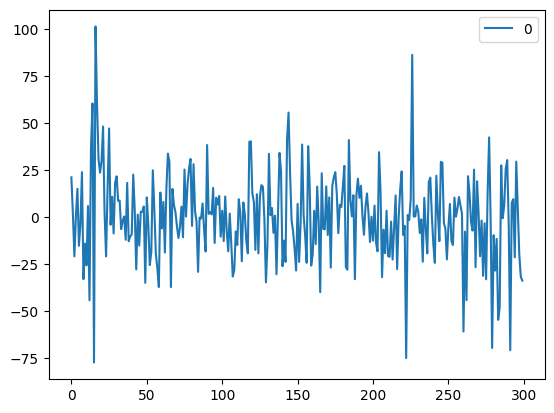

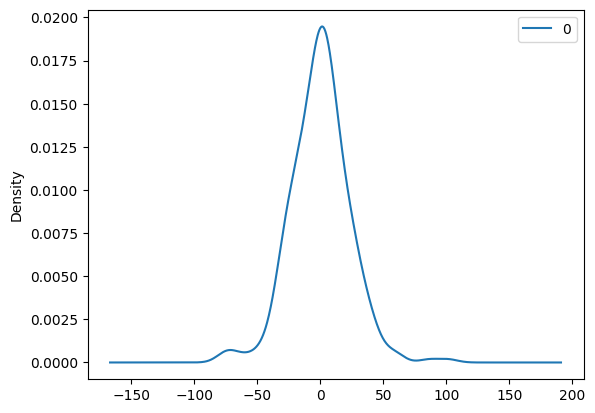

                0
count  300.000000
mean    -0.069304
std     23.232264
min    -77.367943
25%    -13.788129
50%      0.749117
75%     12.575179
max    101.456995


In [50]:
more_info = pd.DataFrame(model_fit.resid)
more_info.plot()
plt.show()
more_info.plot(kind='kde')
plt.show()
print(more_info.describe())

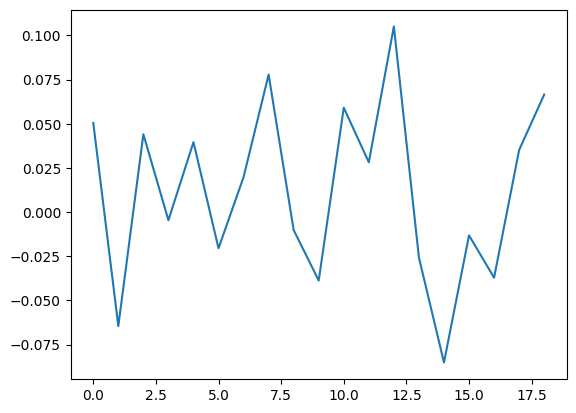

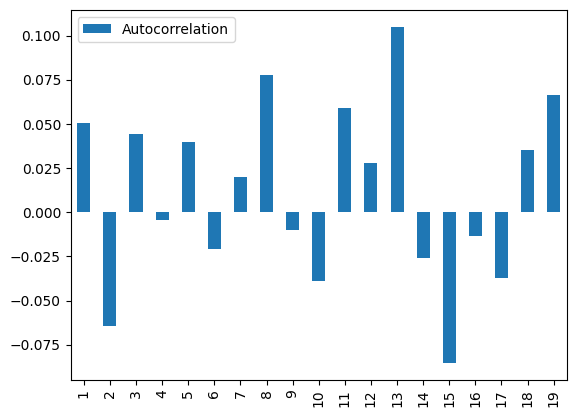

In [51]:
# plot the acf for the residuals
auto_corr_func = acf(model_fit.resid)[1:20]
plt.plot(auto_corr_func)
test_df = pd.DataFrame([auto_corr_func]).T
test_df.columns = ["Autocorrelation"]
test_df.index += 1
test_df.plot(kind='bar')
plt.show()

Training ANN

In [52]:
# choose model type
if (cfg.model_type == 'lstm'):
    model = utl.make_lstm_model()
else:
    model = utl.make_model(cfg.win_sz)

#normalizing input data
mms = preprocessing.MinMaxScaler()
train = np.array(train).reshape(-1, 1)
# todo may test must be used here
train_scaled = mms.fit_transform(train)

# moving window by window
train_x, train_y = [], []
for i in range(0, len(train_scaled) - cfg.win_sz):
    train_x.append(train_scaled[i:i + cfg.win_sz])
    train_y.append(train_scaled[i + cfg.win_sz])

new_train_X, new_train_Y = [], []
for i in train_x:
    new_train_X.append(i.reshape(-1))
for i in train_y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)

his = model.fit(
    new_train_X, new_train_Y,
    epochs=cfg.epoch,
    batch_size=cfg.batch_sz,
    validation_split=cfg.vld_spl,
    verbose=cfg.verbose)

D:\projects\ARIMA_ANN\venv\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Drawing train vs validation loss value

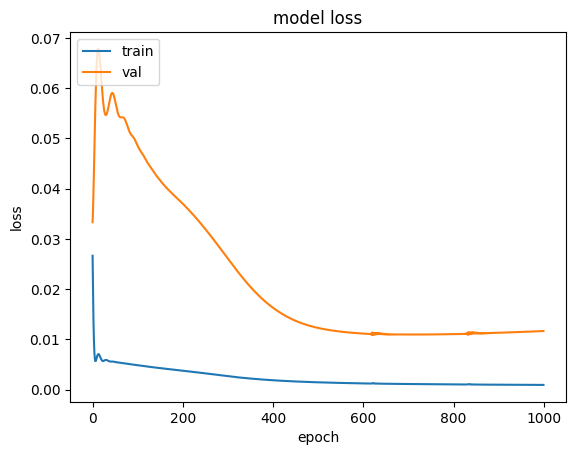

In [53]:
# draw ann performance
utl.draw_nn_perf(his)


moving window by window for testing data and normalizing data

In [54]:
test_extended = train.tolist()[-1 * cfg.win_sz:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1, 1)

# normalizing test data
mms = preprocessing.MinMaxScaler()
test_scaled = mms.fit_transform(test_data)
test_X, test_Y = [], []
for i in range(0, len(test_scaled) - cfg.win_sz):
    test_X.append(test_scaled[i:i + cfg.win_sz])
    test_Y.append(test_scaled[i + cfg.win_sz])
    new_test_X, new_test_Y = [], []
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)

# denormalizing test data
predictions = model.predict(new_test_X)
predictions_rescaled = mms.inverse_transform(predictions)
y = pd.DataFrame(new_train_Y)
#pred = pd.DataFrame(predictions)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A585826CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Visualizing predicted (by ANN) data vs actual data

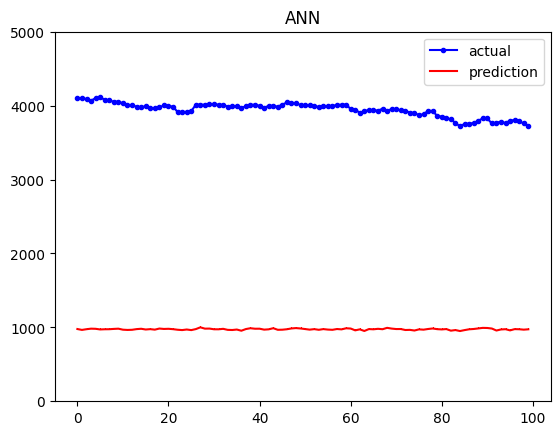

In [55]:
plt.ylim(cfg.ylim)
plt.plot(
    test[start_outlayer: len(predictions)],
    label='actual',
    color='blue',
    marker='.')
tmp = predictions_rescaled[start_outlayer:]
plt.plot(
    tmp,
    label='prediction',
    color='red',
    marker=',')
plt.title('ANN')
plt.legend()
plt.show()

Printing ANN performance 

In [56]:
utl.print_errors(
    'ANN',
    test[start_outlayer:],
    predictions_rescaled[start_outlayer:])

print(50*'#')

MSE (ANN): 8842529.164
ME (ANN): -2972.131
MAE (ANN): 2972.131
MAPE (ANN): 75.298
##################################################


Mixing ANN and ARIMA as hybrid method

In [57]:
predictions_rescaled = predictions_rescaled.squeeze()
pred_final = predictions_rescaled + arima_pred

# removing DC offset
m1 = np.mean(pred_final)
m2 = np.mean(test)
pred_final += m2 - m1


Visualizing and printing performance of hybrid method

MSE (Hybrid): 12930.914
ME (Hybrid): -110.851
MAE (Hybrid): 110.851
MAPE (Hybrid): 2.809


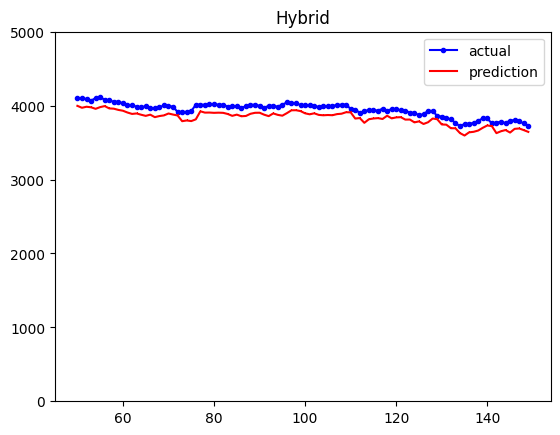

In [58]:
utl.print_errors(
    'Hybrid',
    test[start_outlayer:],
    pred_final[start_outlayer:])

y = pd.DataFrame(test)
pred = pd.DataFrame(pred_final)
plt.plot(
    y[start_outlayer:],
    label='actual',
    color='blue',
    marker='.')
plt.plot(
    pred[start_outlayer:],
    label='prediction',
    color='red',
    marker=',')
plt.title('Hybrid')
plt.ylim(cfg.ylim)
plt.legend()
plt.show()



Drawing 45 degree graphs

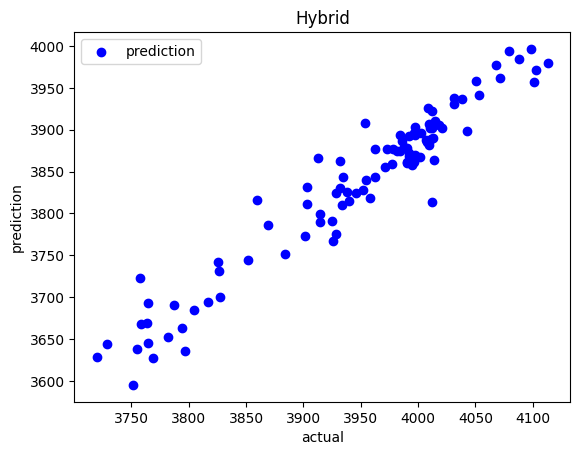

AttributeError: module 'util' has no attribute 'predict_lin_reg'

In [59]:
plt.scatter(
    y[start_outlayer:],
    pred[start_outlayer:],
    marker='o',
    label='prediction',
    color='blue')

plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('Hybrid')
plt.legend()
plt.show()

y_lin_reg = utl.predict_lin_reg(
    test[start_outlayer:],
    pred[start_outlayer:])

tmp = np.array(pred[0], pred[len(pred)-1])

print(tmp)
